In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tools import make_track, ols_regression, make_ER, lasso_regression, lasso_regression_ic, ridge_regression, \
    kalman_filter, kalman_with_selection, selective_kalman_filter, replication_stats, ml_kalman_filter, \
    ml_kalman_filter2
from clustering import cluster, cluster_net
from hc_graph import hc_stock, hc_piechart, hc_spiderweb

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [3]:
fund_name = 'HFRXGL'
pd.read_csv(r"financial_data/hfrx_index_names.csv", index_col=0)

,Full Name
Name,
HFRXAR,HFRX Absolute Return Index
HFRXDS,HFRX ED: Distressed Restructuring Index
HFRXMA,HFRX ED: Merger Arbitrage Index
HFRXSS,HFRX ED: Special Situations Index
HFRXEMN,HFRX EH: Equity Market Neutral Index
HFRXEHG,HFRX EH: Fundamental Growth Index
HFRXEHV,HFRX EH: Fundamental Value Index
HFRXEMC,HFRX Emerging Markets Composite Index
HFRXEWC,HFRX Equal Weighted Strategies CHF Index


### Financial data loads and cleaning

In [4]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
hfrx = make_ER(hfrx_all[[fund_name]].dropna(), US_rate)

# BNP

bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True) #[["BNPIFEU","BNPIFUS",
                 #"BNPIFJP","BNPIFCN","BNPIFFR","BNPIFGE","BNPIFGB","BNPIFCH","BNPIFKR","BNPIFUSC","BNPIFBR",
                 #"BNPIFAU","BNPIFHK","BNPIFTW","BNPIFSG","BNPIFIT","BNPIFSP","BNPIFSW","BNPIFNE","BNPIFRU","BNPIFEM"]]

risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl") #[["BNPICCE3","BNPIVMRU","BNPIAIRT","BNPIAIRU",
                  #"BNPIEC03","BNPIPLEE","BNPIPMEE","BNPIPQEE","BNPIPVEE","BNPILUEE","BNPIPMUH","BNPIPQUH",
                  #"BNPIPVUH","BNPIAIRG","BNPIAIRJ","BNPIAIRE"]]

In [5]:
df_info = pd.read_csv(r"financial_data/bnp_info.csv", index_col=0)
df_info.head()

,Asset Class,Style
Ticker,,
BNPIDRXA,Commodity,Carry
BNPIF3AX,Commodity,Carry
BNPIF3XM,Commodity,Momentum
BPFXSTGU,FX,Value
BNPICCE3,Equity,Carry


In [6]:
prices_all = bnp.join(risk_premia,how="inner").ffill().join(hfrx,how="inner")
prices_all.head()

,BNPIFEU,BNPIFUS,BNPIFJP,BNPIFCN,BNPIFFR,BNPIFGE,BNPIFGB,BNPIFCH,BNPIFKR,BNPIFUSC,...,BNPIPQEE,BNPIPVEE,BNPILUEE,BNPIPMUH,BNPIPQUH,BNPIPVUH,BNPIMDEA,BNPIAIFH,BNPICVXA,HFRXGL
2007-01-03,251.659037,221.446381,123.569027,122.453216,213.419777,187.351929,143.396494,295.276204,289.6684,214.633123,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.13931
2007-01-04,250.891929,221.752767,124.485468,116.840530,212.022884,186.812785,142.625314,294.978808,285.5191,215.297053,...,0.996090,0.995580,0.997660,1.001242,1.000243,0.996902,1.000146,1.0,1.0,1.13821
2007-01-05,247.941926,220.296431,122.435019,116.354951,210.202422,184.800752,141.220705,294.559578,283.5307,211.436575,...,1.000518,1.000001,0.996420,0.999333,0.999586,0.998485,0.989704,1.0,1.0,1.13375
2007-01-08,247.619806,220.849207,122.435019,114.489675,209.896589,184.914022,140.466947,292.889470,280.1748,211.660237,...,1.005248,1.002365,0.997761,1.000212,0.998146,0.996573,0.988449,1.0,1.0,1.13288
2007-01-09,247.980535,220.738811,123.630465,112.996176,210.556213,185.164783,140.518570,293.917702,281.4930,211.994064,...,1.005052,1.002498,0.999367,1.001821,0.995801,0.994901,0.988940,1.0,1.0,1.13334


In [7]:
returns_all = prices_all.pct_change().iloc[1:]
hrfx_returns = returns_all[[fund_name]]
returns_all = returns_all.drop(fund_name, axis=1)
returns_fut = returns_all[bnp.columns]
returns_risk_premia = returns_all[risk_premia.columns]
prices_all = prices_all.drop(fund_name, axis=1)
prices_all = prices_all.bfill()
prices_futur = prices_all[bnp.columns]
prices_risk_premia = prices_all[risk_premia.columns]

## Estimation of the exposures

In [8]:
size = 126
freq = 5

In [9]:
%%time
nu = 1.0
df_weight_kalman = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu)

prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:]

Wall time: 1.34 s


### Volatility adjustment

In [10]:
tau = 0.1
tc = 0.0005
nu = 1.0
lag = 1


In [11]:
%%time

df_weight_kalman_aic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True)
df_weight_kalman_bic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True)
df_weight_kalman_voladj = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu, vol_target=True)
df_weight_ml_kalman_voladj, _ = ml_kalman_filter(hrfx_returns, returns_all,freq, tau=tau, vol_target=True)

prices_for_track = prices_all.loc[df_weight_kalman_aic_voladj.index[0]:]

replication_kalman_aic_voladj = make_track(prices_for_track, df_weight_kalman_aic_voladj, tc=tc, lag=lag)
df_res_voladj = hfrx.loc[replication_kalman_aic_voladj.index]
df_res_voladj["Kalman AIC all"] = replication_kalman_aic_voladj

replication_kalman_bic_voladj = make_track(prices_for_track, df_weight_kalman_bic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman BIC all"] = replication_kalman_bic_voladj

prices_for_track = prices_all.loc[df_weight_kalman_voladj.index[0]:]

replication_kalman_voladj = make_track(prices_for_track, df_weight_kalman_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman all"] = replication_kalman_voladj

Wall time: 1min 21s


In [12]:
%%time
##fut

df_weight_kalman_aic_voladj_fut = selective_kalman_filter(hrfx_returns, returns_fut,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True)

df_weight_kalman_bic_voladj_fut = selective_kalman_filter(hrfx_returns, returns_fut,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True)

df_weight_kalman_voladj_fut = kalman_filter(hrfx_returns, returns_fut,freq, sigma_weight=1. , sigma_return=nu, vol_target=True)
df_weight_ml_kalman_voladj_fut, _ = ml_kalman_filter(hrfx_returns, returns_fut,freq, tau=tau, vol_target=True)

prices_for_track = prices_futur.loc[df_weight_kalman_aic_voladj_fut.index[0]:]

replication_kalman_aic_voladj_fut = make_track(prices_for_track, df_weight_kalman_aic_voladj_fut, tc=tc, lag=lag)
df_res_voladj_fut = hfrx.loc[replication_kalman_aic_voladj_fut.index]
df_res_voladj_fut["Kalman AIC futures"] = replication_kalman_aic_voladj_fut

replication_kalman_bic_voladj_fut = make_track(prices_for_track, df_weight_kalman_bic_voladj_fut, tc=tc, lag=lag)
df_res_voladj_fut["Kalman BIC futures"] = replication_kalman_bic_voladj_fut

prices_for_track = prices_futur.loc[df_weight_kalman_voladj_fut.index[0]:]

replication_kalman_voladj_fut = make_track(prices_for_track, df_weight_kalman_voladj_fut, tc=tc, lag=lag)
df_res_voladj_fut["Kalman futures"] = replication_kalman_voladj_fut


Wall time: 58.7 s


In [13]:
%%time
## Risk Premia

df_weight_kalman_aic_voladj_risk_premia = selective_kalman_filter(hrfx_returns, returns_risk_premia,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True)
df_weight_kalman_bic_voladj_risk_premia = selective_kalman_filter(hrfx_returns, returns_risk_premia,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True)
df_weight_kalman_voladj_risk_premia = kalman_filter(hrfx_returns, returns_risk_premia,freq, sigma_weight=1. , sigma_return=nu, vol_target=True)
df_weight_ml_kalman_voladj_risk_premia, _ = ml_kalman_filter(hrfx_returns, returns_risk_premia,freq, tau=tau, vol_target=True)

prices_for_track = prices_risk_premia.loc[df_weight_kalman_aic_voladj_risk_premia.index[0]:]

replication_kalman_aic_voladj_risk_premia = make_track(prices_for_track, df_weight_kalman_aic_voladj_risk_premia, tc=tc, lag=lag)
df_res_voladj_risk_premia = hfrx.loc[replication_kalman_aic_voladj_risk_premia.index]
df_res_voladj_risk_premia["Kalman AIC Risk Premia"] = replication_kalman_aic_voladj_risk_premia

replication_kalman_bic_voladj_risk_premia = make_track(prices_for_track, df_weight_kalman_bic_voladj_risk_premia, tc=tc, lag=lag)
df_res_voladj_risk_premia["Kalman BIC Risk Premia"] = replication_kalman_bic_voladj_risk_premia

prices_for_track = prices_risk_premia.loc[df_weight_kalman_voladj_risk_premia.index[0]:]

replication_kalman_voladj_risk_premia = make_track(prices_for_track, df_weight_kalman_voladj_risk_premia, tc=tc, lag=lag)
df_res_voladj_risk_premia["Kalman Risk Premia"] = replication_kalman_voladj_risk_premia

C:\Users\Maxence\Documents\Centrale 3eme année\OMA\Projet - BNP - Replication HF\Hedge-Fund-Replication-master\Hedge-Fund-Replication\tools.py:370: RuntimeWarning: divide by zero encountered in double_scalars
  leverage = port_vol / repli_vol
C:\Users\Maxence\Documents\Centrale 3eme année\OMA\Projet - BNP - Replication HF\Hedge-Fund-Replication-master\Hedge-Fund-Replication\tools.py:371: RuntimeWarning: invalid value encountered in multiply
  df_weight.loc[date] = leverage * weight[:, 0].T


Wall time: 50 s


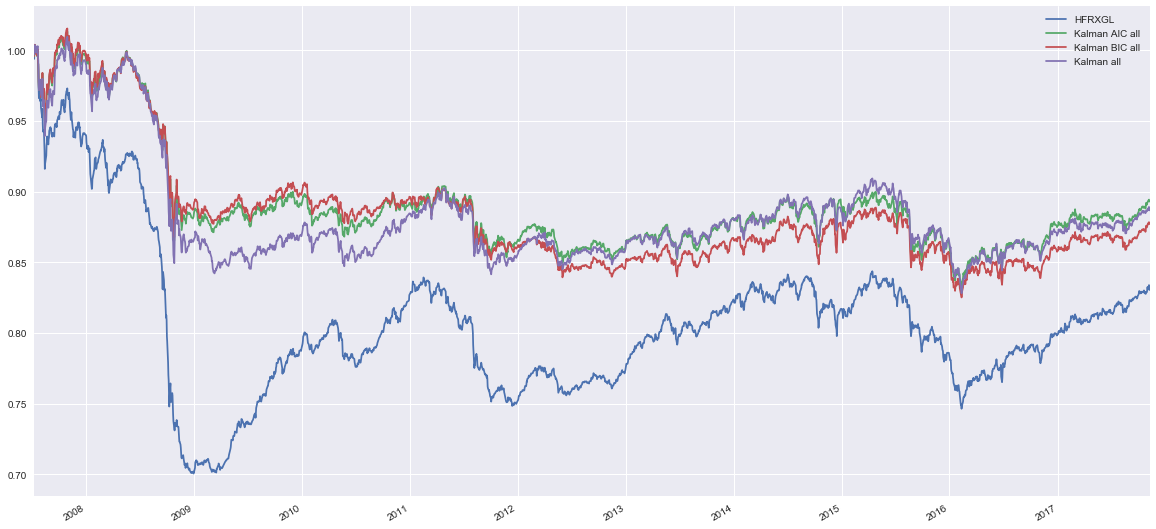

In [14]:
df_res_voladj = df_res_voladj.bfill()
df_res_voladj = (df_res_voladj / df_res_voladj.iloc[0])
df_res_volperfadj = df_res_voladj[[fund_name]].copy()
temp = df_res_voladj.drop(fund_name, axis=1)
df_res_volperfadj[temp.columns]= make_ER(temp, 2 + 0 * US_rate)
df_res_volperfadj.plot(figsize=(20,10))

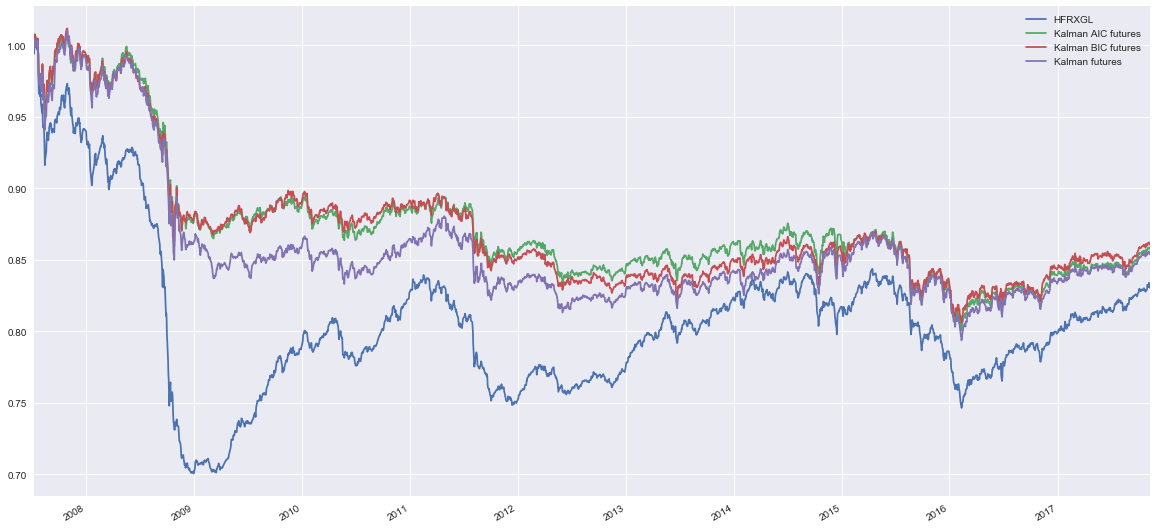

In [15]:
df_res_voladj_fut = df_res_voladj_fut.bfill()
df_res_voladj_fut = (df_res_voladj_fut / df_res_voladj_fut.iloc[0])
df_res_volperfadj_fut = df_res_voladj_fut[[fund_name]].copy()
temp = df_res_voladj_fut.drop(fund_name, axis=1)
df_res_volperfadj_fut[temp.columns]= make_ER(temp, 2 + 0 * US_rate)
df_res_volperfadj_fut.plot(figsize=(20,10))

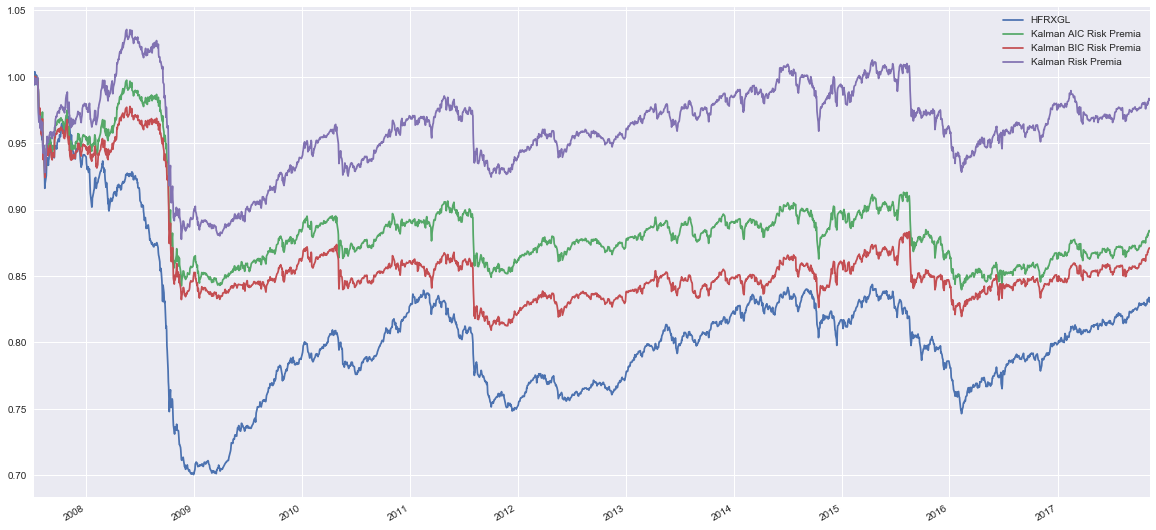

In [16]:
df_res_voladj_risk_premia = df_res_voladj_risk_premia.bfill()
df_res_voladj_risk_premia = (df_res_voladj_risk_premia / df_res_voladj_risk_premia.iloc[0])
df_res_volperfadj_risk_premia = df_res_voladj_risk_premia[[fund_name]].copy()
temp = df_res_voladj_risk_premia.drop(fund_name, axis=1)
df_res_volperfadj_risk_premia[temp.columns]= make_ER(temp, 2 + 0 * US_rate)
df_res_volperfadj_risk_premia.plot(figsize=(20,10))

## Statistics on replication

In [17]:
df_stat_vol = replication_stats(df_res_voladj, fund_name=fund_name)
df_stat_vol

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
HFRXGL,0.000000,1.000000,-0.438607,-0.018112,1.000000,1.000000
Kalman AIC all,0.001487,0.649145,0.259541,0.009541,0.823575,0.612417
Kalman BIC all,0.001541,0.623306,0.214496,0.007754,0.810917,0.590590
Kalman all,0.001431,0.675275,0.237488,0.008846,0.840624,0.631320


In [18]:
df_stat_vol_fut = replication_stats(df_res_voladj_fut, fund_name=fund_name)
df_stat_vol_fut

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
HFRXGL,0.000000,1.000000,-0.438607,-0.018112,1.000000,1.000000
Kalman AIC futures,0.001494,0.646017,0.158600,0.005528,0.822581,0.609470
Kalman BIC futures,0.001540,0.624033,0.167840,0.005887,0.811162,0.592118
Kalman futures,0.001466,0.659246,0.145391,0.005107,0.833669,0.624917


In [19]:
df_stat_vol_risk_premia = replication_stats(df_res_voladj_risk_premia, fund_name=fund_name)
df_stat_vol_risk_premia

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
HFRXGL,0.000000,1.000000,-0.438607,-0.018112,1.000000,1.000000
Kalman AIC Risk Premia,0.002033,0.344393,0.225314,0.008485,0.684351,0.466285
Kalman BIC Risk Premia,0.002094,0.304821,0.188270,0.007069,0.672960,0.456189
Kalman Risk Premia,0.001953,0.395321,0.487718,0.019078,0.702159,0.481958
